In [22]:
import tweepy
import pandas as pd
import configparser
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [23]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

In [24]:
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

In [25]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [26]:
#posts = tweepy.Cursor(api.user_timeline, screen_name="ArvindKejriwal", count = 200, tweet_mode="extended").items((300))

In [27]:
posts = tweepy.Cursor(api.search_tweets, q="#bitcoin", count = 200, lang ="en", tweet_mode="extended").items((100))

In [28]:
df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])

In [29]:
df

,Tweets
0,RT @BitcoinMagazine: #Bitcoin is a better opti...
1,#Bitcoin trying to break his downtrend. Think ...
2,RT @Dennis_Porter_: BREAKING NEWS: Jack Dorsey...
3,#AinuBall is the first duelling #P2E game. It...
4,RT @Cointelegraph: The #Bitcoin standard makes...
...,...
95,RT @ShibaZuna: Here's a glimpse of our Nft Gam...
96,"RT @MatthewHyland_: Shorter time frame (1HR), ..."
97,RT @MartiniGuyYT: WOW 🤩 #BITCOIN MOONING! 🚀🌙
98,RT @BitcoinMagazine: “#Bitcoin incentivizes lo...


In [30]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [31]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub("\n","",text) # Removing hyperlink
    text = re.sub(":","",text) # Removing hyperlink
    text = re.sub("_","",text) # Removing hyperlink
    text = emoji_pattern.sub(r'', text)
    return text


# Clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTxt)
discard = ["CNFTGiveaway", "IVEAWAYPrizes", "Giveaway", "Airdrop"]
df = df[~df["Tweets"].str.contains('|'.join(discard))]

In [32]:
df

,Tweets
0,"Bitcoin is a better option than fiat, said Me..."
1,Bitcoin trying to break his downtrend. Think L...
2,Porter BREAKING NEWS Jack Dorsey supports Pro-...
3,AinuBall is the first duelling P2E game. It i...
4,The Bitcoin standard makes you think long-ter...
...,...
95,Here's a glimpse of our Nft Game that we are ...
96,"Shorter time frame (1HR), Bitcoin needs to re..."
97,WOW BITCOIN MOONING!
98,“Bitcoin incentivizes long-term thinking acro...


In [33]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df

<ipython-input-33-d444dd8f48c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
<ipython-input-33-d444dd8f48c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['Tweets'].apply(getPolarity)


,Tweets,Subjectivity,Polarity
0,"Bitcoin is a better option than fiat, said Me...",0.250000,0.250000
1,Bitcoin trying to break his downtrend. Think L...,0.400000,-0.050000
2,Porter BREAKING NEWS Jack Dorsey supports Pro-...,0.500000,0.500000
3,AinuBall is the first duelling P2E game. It i...,0.244444,-0.050000
4,The Bitcoin standard makes you think long-ter...,0.000000,0.000000
...,...,...,...
95,Here's a glimpse of our Nft Game that we are ...,0.400000,-0.400000
96,"Shorter time frame (1HR), Bitcoin needs to re...",0.400000,-0.300000
97,WOW BITCOIN MOONING!,1.000000,0.125000
98,“Bitcoin incentivizes long-term thinking acro...,0.000000,0.000000


In [34]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)
# Show the dataframe
df

<ipython-input-34-5984e99df0d4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = df['Polarity'].apply(getAnalysis)


,Tweets,Subjectivity,Polarity,Analysis
0,"Bitcoin is a better option than fiat, said Me...",0.250000,0.250000,Positive
1,Bitcoin trying to break his downtrend. Think L...,0.400000,-0.050000,Negative
2,Porter BREAKING NEWS Jack Dorsey supports Pro-...,0.500000,0.500000,Positive
3,AinuBall is the first duelling P2E game. It i...,0.244444,-0.050000,Negative
4,The Bitcoin standard makes you think long-ter...,0.000000,0.000000,Neutral
...,...,...,...,...
95,Here's a glimpse of our Nft Game that we are ...,0.400000,-0.400000,Negative
96,"Shorter time frame (1HR), Bitcoin needs to re...",0.400000,-0.300000,Negative
97,WOW BITCOIN MOONING!,1.000000,0.125000,Positive
98,“Bitcoin incentivizes long-term thinking acro...,0.000000,0.000000,Neutral


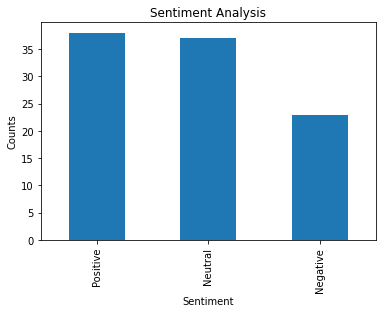

In [35]:


# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

